# Рекомендация тарифов

Оператору мобильной связи «Мегалайн» необходимо построить систему, способную проанализировать поведение клиентов на основании их архивных данных и предложить им новый тариф: «Смарт» или «Ультра».

**Цель исследования** — <u>построить модели и выбрать ту, у которой натбольший accuracy (не менее 0.75) </u> <a id='hypothesis'></a>

**Ход исследования:**

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Так как предобработка данных уже проведена, исследование пройдёт в 6 этапов:
 1. Обзор данных.
 2. Разбиение данных на выборки.
 3. Исследование моделей.
 4. Проверка моделей на тестовой выборке.
 5. Проверка моделей на адекватность.
 6. Общий вывод.

## Обзор данных

In [10]:
import pandas as pd
import sklearn 
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.dummy import DummyClassifier

from tqdm import tqdm
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv('/datasets/users_behavior.csv')
display(df.head(10))
display(df.info())
display(df.describe())
print('Количество дубликатов:', df.duplicated().sum())

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Количество дубликатов: 0


**Столбцы:**

- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

### Вывод
В датафрейме 5 столбцов и 3214 строк с информацией о потреблении трафика пользователей тарифов «Смарт» или «Ультра». 
Видно, что наша выборка несбалансированная: около 30% клиентов используют тариф «Ультра», 70% - «Смарт».

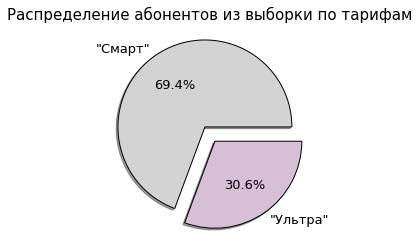

In [12]:
tariffs_pivot = df.pivot_table(index='is_ultra', values='calls', aggfunc='count')

values = tariffs_pivot['calls'].values.tolist()
labels = ['"Смарт"', '"Ультра"']

fig, ax = plt.subplots()

ax.pie(values, labels=labels, autopct='%1.1f%%', colors = ['lightgrey', 'thistle'], 
           wedgeprops = {'lw':1, 'ls':'-','edgecolor':'black'},
           explode = [0.1, 0.1], shadow = True, textprops={'fontsize': 13})
plt.title('Распределение абонентов из выборки по тарифам', fontsize = 15)         
plt.show()

## Разбиение данных на выборки

In [13]:
# разобъем исходные данные на тестовую и оставшуюся выборку в соотношении 1:4
# получим df_test, равную 20% от исходного df
df_remain, df_test = train_test_split(df, test_size=0.2, random_state=12345, stratify=df['is_ultra'])

# разобъем оставшуюся выборку на обучающую и валидационную в соотношении 1:3
# получим df_train, df_valid, 60% и 20% от исходного df соответственно
df_train, df_valid = train_test_split(df_remain, test_size=0.25, random_state=12345, stratify=df_remain['is_ultra'])

Убедимся, что сохранили изначальное распределение таргетов во всех новых датасетах. Посмотрим на круговые диаграммы распределения абонетов по тарифам:

3it [00:00, 64.80it/s]


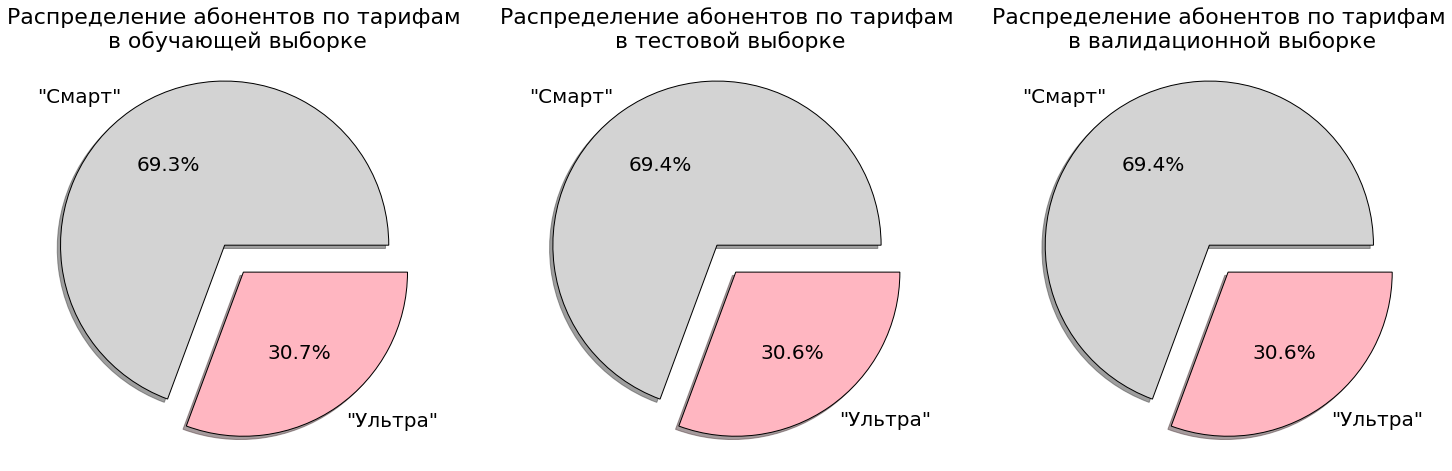

In [14]:
fig = plt.figure(figsize=(25,25))

for sample, s_name, i in tqdm(zip([df_train, df_test, df_valid], 
                                  ['обучающей', 'тестовой', 'валидационной'],
                                  [0,1,2])):

    values = sample['is_ultra'].value_counts().tolist()
    labels = ['"Смарт"', '"Ультра"']    
    ax1 = plt.subplot2grid((1,3),(0,i))       
    plt.pie(values, labels=labels, autopct='%1.1f%%', colors = ['lightgrey', 'lightpink'], 
               wedgeprops = {'lw':1, 'ls':'-','edgecolor':'black'},
               explode = [0.1, 0.1], shadow = True, textprops={'fontsize': 20})
    plt.title(f'Распределение абонентов по тарифам\n в {s_name} выборке', fontsize = 22) 
    
plt.show()

In [15]:
# для каждой выборки объявим признаки features и целевой признак target
selection_types = ['train', 'test', 'valid','remain']
for type in selection_types:
    globals()['features_%s' % type] = globals()['df_%s' % type].drop('is_ultra', axis=1)
    globals()['target_%s' % type] = globals()['df_%s' % type]['is_ultra']
    
    # выведем переменные с признаками:
    print(f'features_{type}')
    display((globals()['features_%s' % type]).sample(5))
    
    # и с целевыми признакми:
    print(f'target_{type}')
    display((globals()['target_%s' % type]).sample(5))

    # выведем доли выборок от исходных данных:
    print(f'Доля df_{type} от исходного df -', int(round(len(globals()['df_%s' % type]) / len(df),2)*100),'%')
    print()

features_train


,calls,minutes,messages,mb_used
2123,34.0,252.87,26.0,24550.06
2444,71.0,528.33,17.0,19918.66
1598,0.0,0.00,28.0,16573.03
1883,55.0,388.18,40.0,12398.26
934,70.0,450.03,51.0,17567.13


target_train


108     1
990     0
462     1
726     0
2230    0
Name: is_ultra, dtype: int64

Доля df_train от исходного df - 60 %

features_test


,calls,minutes,messages,mb_used
902,98.0,657.01,70.0,13309.90
2053,72.0,490.54,64.0,12550.98
754,98.0,723.12,10.0,14688.44
1283,60.0,427.29,6.0,7023.77
1119,72.0,415.28,25.0,30960.74


target_test


3175    0
2509    0
2972    0
205     1
511     0
Name: is_ultra, dtype: int64

Доля df_test от исходного df - 20 %

features_valid


,calls,minutes,messages,mb_used
2475,29.0,136.48,0.0,18100.45
2214,69.0,538.58,64.0,28639.49
45,35.0,235.58,97.0,20710.71
1299,76.0,501.18,0.0,16152.55
3088,122.0,783.69,0.0,17135.40


target_valid


2803    0
2261    0
1611    0
1268    0
2529    0
Name: is_ultra, dtype: int64

Доля df_valid от исходного df - 20 %

features_remain


,calls,minutes,messages,mb_used
2314,32.0,182.24,131.0,23932.64
1247,55.0,389.33,29.0,25047.08
2004,59.0,452.15,47.0,13053.02
976,43.0,321.24,6.0,8395.77
936,75.0,520.47,0.0,18194.45


target_remain


1285    0
1161    1
633     0
1182    0
1488    0
Name: is_ultra, dtype: int64

Доля df_remain от исходного df - 80 %



### Вывод

Мы разбили данные на три выборки: обучающую, валидационную и тестовую в соотношении 3:1:1 соответственно, сохранив при этом соотношение таргетов.

## Исследование моделей

### Decision Tree 

100%|██████████| 12/12 [00:01<00:00,  9.17it/s]


Accuracy наилучшей модели на валидационной выборке:0.8164852255054432

Максимальная глубина: 5
Минимальное количество объектов в промежуточном узле: 2
Минимальное количество объектов в листе: 1


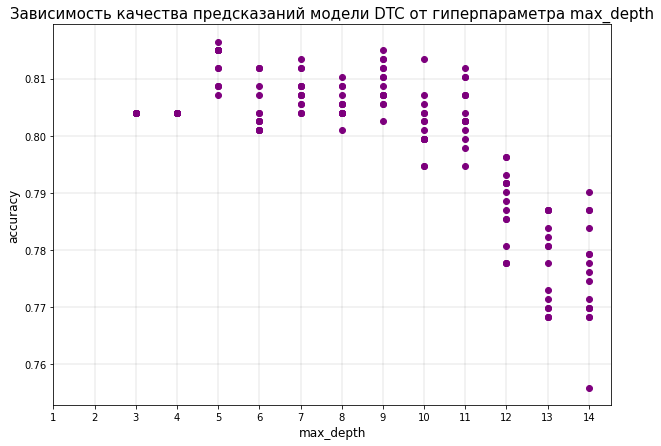

In [16]:
best_accuracy = 0

x_max_depth = []
y_accuracy = []

for depth in tqdm(range(3, 15)):
    for sample_s in [2,4,8,16]:
        for sample_l in range(1,5):
            model = DecisionTreeClassifier(max_depth=depth, min_samples_split = sample_s, 
                                           min_samples_leaf=sample_l, random_state=12345)
            model.fit(features_train, target_train) # обучаем модель
            predictions_valid = model.predict(features_valid) # получаем предсказания модели
            accuracy = accuracy_score(target_valid, predictions_valid) # считаем качество модели
            if accuracy > best_accuracy:
                best_dtc_model = model
                best_accuracy = accuracy
                best_depth = depth
                best_sample_l = sample_l
                best_sample_s = sample_s
                
            x_max_depth.append(depth)
            y_accuracy.append(accuracy)
            
def accuracy_scatter(x_max_depth,y_accuracy, model_name):
    plt.figure(figsize=(10,7))
    plt.scatter(x_max_depth,y_accuracy, color = 'purple')
    plt.title(f'Зависимость качества предсказаний модели {model_name} от гиперпараметра max_depth', fontsize = 15)
    plt.xlabel('max_depth', fontsize = 12)
    plt.ylabel('accuracy', fontsize = 12)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(15)

    plt.grid(linestyle='-', linewidth='0.1', color='black')          
    plt.xticks(range(1,15))
    plt.show()
                
        
print(f'Accuracy наилучшей модели на валидационной выборке:{best_accuracy}\n\
\nМаксимальная глубина: {best_depth}\nМинимальное количество объектов в промежуточном узле: {best_sample_s}\n\
Минимальное количество объектов в листе: {best_sample_l}')
accuracy_scatter(x_max_depth,y_accuracy, 'DTC')

На графике можно наблюдать недообучение модели при при высоте дерева до 5 условий. Перенасыщение происходит после достижения высоты в 9 условий. Точность предсказаний для обучающей выборки будет расти вместе с глубиной дерева.

### Random Forest 

100%|██████████| 12/12 [00:11<00:00,  1.07it/s]

Accuracy наилучшей модели на валидационной выборке:0.8320373250388803
Количество деревьев: 10
Максимальная глубина: 8
Минимальное количество объектов в листе: 1


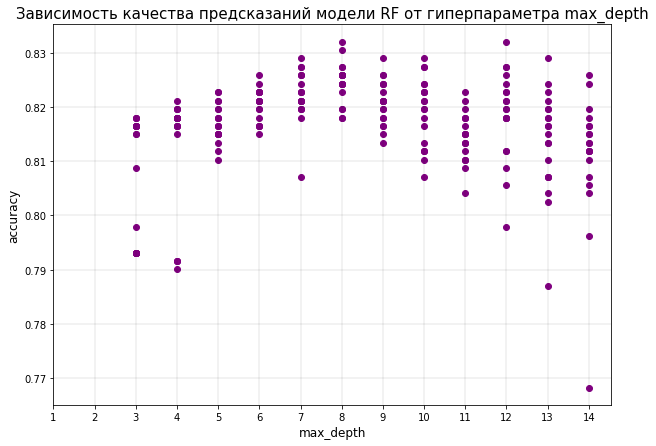

In [17]:
best_accuracy = 0
x_max_depth = []
y_accuracy = []

for depth in tqdm(range(3, 15)):
    for est in [5,10,15,20,30]:
        for sample in range(1,5):
            model = RandomForestClassifier(max_depth=depth, n_estimators=est, 
                                           min_samples_leaf=sample, random_state=12345) # почему с последним параметром не становится быстрее?
            model.fit(features_train, target_train)
            accuracy = model.score(features_valid, target_valid)
            if accuracy > best_accuracy:
                best_rf_model = model
                best_accuracy = accuracy
                best_depth = depth
                best_est = est
                best_sample = sample
                
            x_max_depth.append(depth)
            y_accuracy.append(accuracy)
            
             
print(f'Accuracy наилучшей модели на валидационной выборке:{best_accuracy}\nКоличество деревьев: {best_est}\
\nМаксимальная глубина: {best_depth}\nМинимальное количество объектов в листе: {best_sample}')

accuracy_scatter(x_max_depth,y_accuracy, 'RF')


До глубины 9 качество модели растет, достигая пика на отметке 8. Кажется, что accuracy перестает зависеть от глубины в отметке 9-11, так как данные заканчиваются раньше, чем дерево доходит до максимальной глубины.

Теперь построим RF с помощью `GridSearchCV`, выведем гиперпараметры лучшей:

In [18]:
rfc = RandomForestClassifier() 
skf = StratifiedKFold(5)
skf.get_n_splits(features_remain, target_remain)


param_grid = { 
    'max_depth': range(3,16),
    'n_estimators': [20,30,50,100],
    'min_samples_leaf': range(1,6),
    
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= skf) 
CV_rfc.fit(features_train, target_train)
print(CV_rfc.best_params_)

{'max_depth': 6, 'min_samples_leaf': 2, 'n_estimators': 50}


Сохраним лучшую модель в best_rf_model_2, выведем accuracy:

In [19]:
best_rf_model_2 = CV_rfc.best_estimator_
accuracy = best_rf_model_2.score(features_valid, target_valid)
accuracy

0.8180404354587869

### Logistic Regression

In [20]:
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_lr.fit(features_train, target_train)
accuracy = model_lr.score(features_valid, target_valid)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7558320373250389


Выведем гистограммы для всех признаков так, чтобы в одной оси были 2 графика для каждого из тарифов:

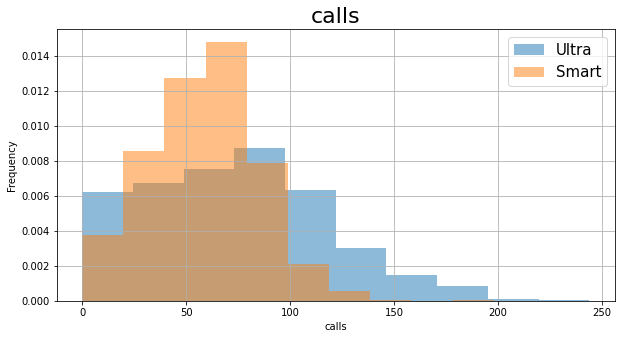

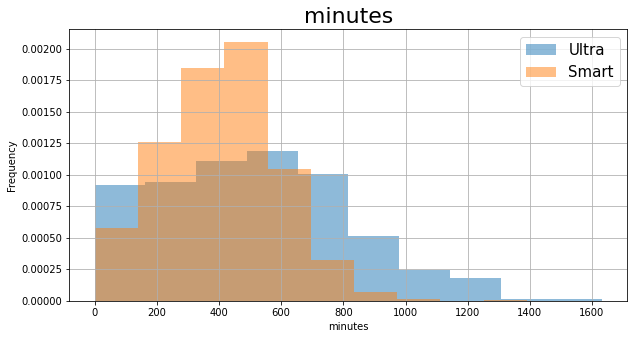

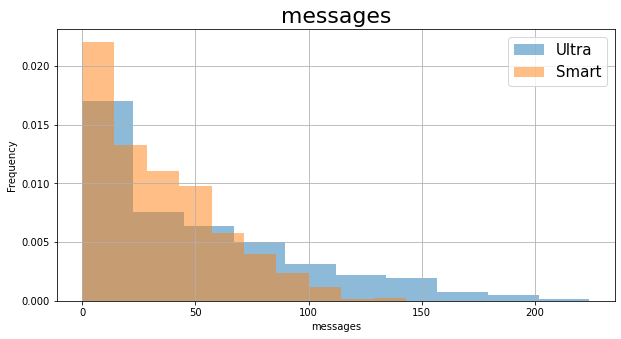

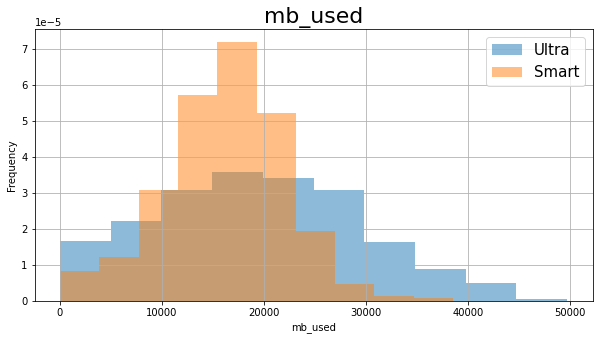

In [21]:
df_ultra = df.query('is_ultra == 1')
df_smart = df.query('is_ultra == 0')

for param in df.drop('is_ultra', axis=1).columns:
    plt.figure(figsize=(10,5))
    ax = plt.gca()
    df_ultra[param].hist(alpha =0.5, density = True, label = 'Ultra')
    df_smart[param].hist(alpha =0.5, density = True, label = 'Smart')
    plt.title(param, fontsize = 22) 
    plt.ylabel('Frequency', fontsize = 10)
    plt.xlabel(param, fontsize = 10)  
    plt.legend(fontsize = 15)
    

### Вывод

Наиболее качественная модель - случайный лес с гиперпараметрами:
- количество деревьев: 10;
- максимальная глубина: 11;
- минимальное количество объектов в листе: 3
и accuracy = 0.8164852255054432.

За ней следует решающее дерево (максимальная глубина: 7; минимальное количество объектов в промежуточном узле: 2;
минимальное количество объектов в листе: 3 и accuracy около 80%). Самая неточная модель - логистическая регрессия с accuracy 68%.

## Проверка модели на тестовой выборке

In [22]:
accuracy = best_rf_model_2.score(features_test, target_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8087091757387247


### Вывод:

Качество `best_rf_model_2` незначительно снизилось - на 1%.

## Проверка моделей на адекватность

Создадим вручную «игрушечную модель», которая считает, что все клиенты - пользователи тарифа «Смарт», измерим ее качество:

In [23]:
dummy_predictions = np.zeros(len(features_test))
dummy_accuracy = (dummy_predictions == target_test).sum()/len(target_test)
dummy_accuracy

0.6936236391912908

Сделаем то же самое с помощью DummyClassifier:

In [24]:
dummy_clf = DummyClassifier(strategy='prior')
dummy_clf.fit(features_train, target_train)
accuracy = dummy_clf.score(features_test, target_test)
accuracy

0.6936236391912908

### Вывод

Мы видим, что модель логистической регрессии практически не работает, она лучше «игрушечной» по качеству всего на 1%. Случайный лес - самая полезная модель, ее качество больше качества «игрушечной» почти на 10%. Решающее дерево, хоть и менее эффективно, но бесполезной назвать эту модель нельзя, ее качество лучше качество «игрушечной модели» почти на 8%.

# Вывод

1. Мы изучили данные и выяснили, что наша выборка несбалансированная: около 30% клиентов используют тариф «Ультра», 70% - «Смарт».

2. Разбили данные на три выборки: обучающую, валидационную и тестовую выборки, в соотношении 3:1:1 соответственно.

3. Рассмотрели 3 вида моделей для задачи классификации: решающее дерево, случайный лес и логистическую регрессию с разными гиперпараметрами.

4. Определили наиболее точную из рассмотренных - случайный лес (`best_rf_model_2`) с гиперпараметрами:
    - количество деревьев: 30;
    - максимальная глубина: 6;
    - минимальное количество объектов в листе: 1.
    
    
5. Измерили качество модели на тестовой выборке(81% точности).
6. Выяснили, что модель логистической регрессии оказалась бесполезной.

**Таким образом, предлагаем оператору «Мегалайн» модель `best_rf_model_2` для рекомендации пользователям тарифов «Смарт» и «Ультра».**

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75